# Stochastic Oscillator
This notebook is designed to backtest the stochastic oscillator as a trading strategy. It calculates the %K and %D values based on historical market data, applying various lookback periods and smoothing techniques. The strategy tests typical trading signals, such as entering long positions when the oscillator indicates oversold conditions and shorting during overbought signals. Through backtesting, the notebook evaluates the performance of this approach, analyzing key metrics such as returns, risk, and overall profitability to determine its effectiveness in different market environments.

## Import Libraries

In [17]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from tabulate import tabulate
import numpy as np

## Stock Data Selection
In this step, we will define the stock symbol and date range for our analysis. In this example, we are using TSLA (Tesla) as the stock symbol, but you can change this to any stock you are interested in. We will also fetch the stock data using the yfinance library.

### Select Stock and Date Range

In [18]:
# Define the stock symbol and the date range for our data
stock_symbol = 'TSLA'
start_date = '2024-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')  # Sets end date to today's date
print(f"Stochastic Oscillator Trading for: {stock_symbol}\nStart Date: {start_date}\nEnd Date: {end_date}")

Stochastic Oscillator Trading for: TSLA
Start Date: 2024-01-01
End Date: 2024-12-03


### Download Data

In [19]:
df = yf.download(stock_symbol, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2024-01-02,248.419998,248.419998,251.250000,244.410004,250.080002,104654200
2024-01-03,238.449997,238.449997,245.679993,236.320007,244.979996,121082600
2024-01-04,237.929993,237.929993,242.699997,237.729996,239.250000,102629300
2024-01-05,237.490005,237.490005,240.119995,234.899994,236.860001,92379400
2024-01-08,240.449997,240.449997,241.250000,235.300003,236.139999,85166600


### Prepare Data

In [20]:
# Select the desired columns (first level of MultiIndex)
df.columns = df.columns.get_level_values(0)

# Keep only the columns you are interested in
df = df[['Open', 'Close', 'Volume', 'Low', 'High']]

# If the index already contains the dates, rename the index
df.index.name = 'Date'  # Ensure the index is named "Date"
    
# Resetting the index if necessary
df.reset_index(inplace=True)

# Ensure that the index is of type datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index again (in case it's reset)
df.set_index('Date', inplace=True)

df.head()

Price,Open,Close,Volume,Low,High
Date,,,,,
2024-01-02,250.080002,248.419998,104654200,244.410004,251.250000
2024-01-03,244.979996,238.449997,121082600,236.320007,245.679993
2024-01-04,239.250000,237.929993,102629300,237.729996,242.699997
2024-01-05,236.860001,237.490005,92379400,234.899994,240.119995
2024-01-08,236.139999,240.449997,85166600,235.300003,241.250000


### Plot Closing Price

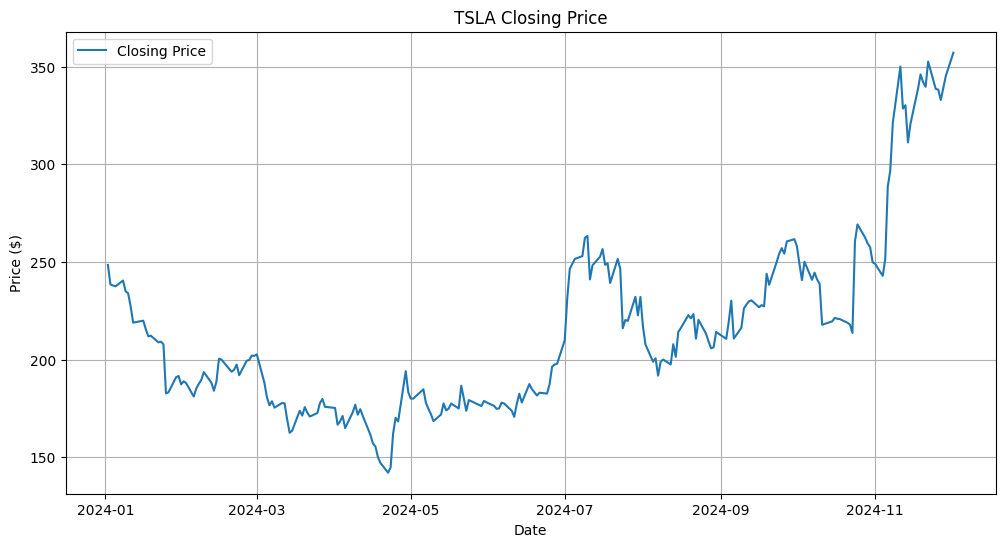

In [21]:
# Set dark mode for the plot
# plt.style.use('dark_background')  # Use dark background style

# Plot the closing price
plt.figure(figsize=(12, 6))

plt.plot(df['Close'], label='Closing Price')  # Change color for visibility

# Add title, labels, and legend with appropriate colors for dark mode
plt.title(f'{stock_symbol} Closing Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stock_chart_darkmode.png', dpi=300)

# Show the plot
plt.show()


## Backtest The Strategy

### Generate Signals

In [22]:
# Calculate the Stochastic Oscillator
lookback_period = 14  # Standard 14-period lookback for %K

# Calculate the highest high and lowest low for the lookback period
df['High_Max'] = df['High'].rolling(window=lookback_period).max()
df['Low_Min'] = df['Low'].rolling(window=lookback_period).min()

# Calculate %K (Stochastic Oscillator)
df['%K'] = 100 * (df['Close'] - df['Low_Min']) / (df['High_Max'] - df['Low_Min'])

# Calculate %D (3-day moving average of %K)
df['%D'] = df['%K'].rolling(window=3).mean()

# Calculate the 20-day moving average to use as a trend filter
df['SMA20'] = df['Close'].rolling(window=20).mean()

# Generate trading signals
df['Signal'] = np.nan  # Default is no signal

# Buy signal when %K crosses above %D (momentum shift) and price is above the 20-day SMA (uptrend)
df.loc[(df['%K'] > df['%D']) & 
       (df['%K'].shift(1) <= df['%D'].shift(1)) & 
       (df['Close'] > df['SMA20']), 'Signal'] = 1  # Buy Signal

# Sell signal when %K crosses below %D (momentum shift) and price is below the 20-day SMA (downtrend)
df.loc[(df['%K'] < df['%D']) & 
       (df['%K'].shift(1) >= df['%D'].shift(1)) & 
       (df['Close'] < df['SMA20']), 'Signal'] = -1  # Sell Signal

### Plot the Stochastic Oscillator (%K and %D)

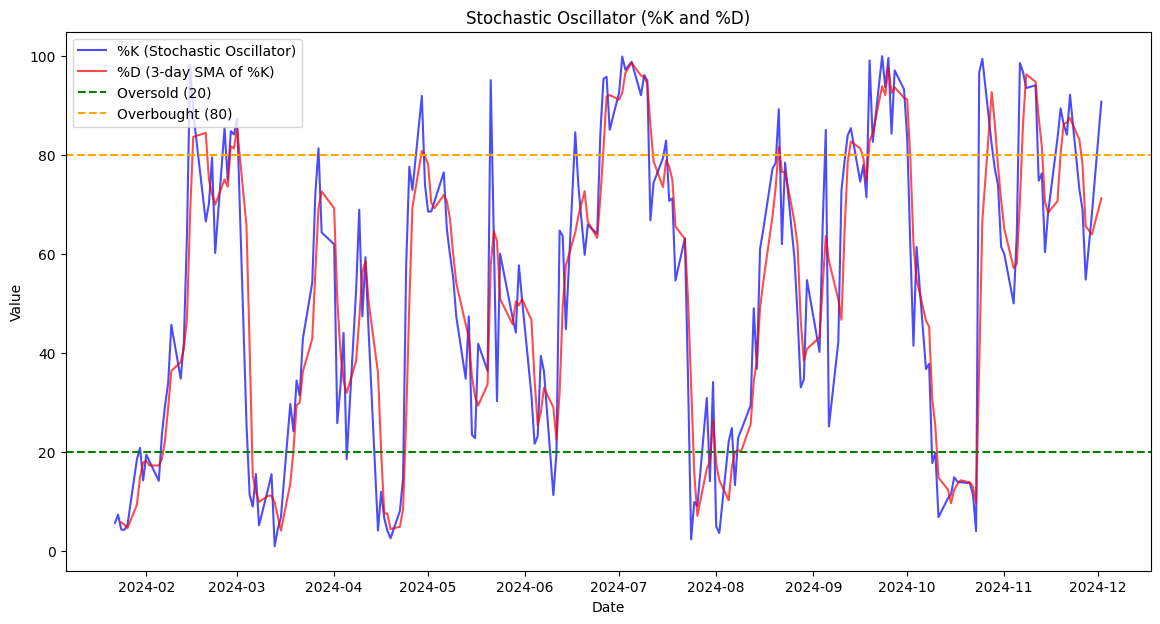

In [23]:
# Plot the Stochastic Oscillator (%K and %D)
plt.figure(figsize=(14,7))

# Plot %K and %D
plt.plot(df.index, df['%K'], label='%K (Stochastic Oscillator)', color='blue', alpha=0.7)
plt.plot(df.index, df['%D'], label='%D (3-day SMA of %K)', color='red', alpha=0.7)

# Add horizontal lines at 20 and 80 (for oversold and overbought levels)
plt.axhline(20, color='green', linestyle='--', label='Oversold (20)')
plt.axhline(80, color='orange', linestyle='--', label='Overbought (80)')

# Set plot labels and title
plt.title('Stochastic Oscillator (%K and %D)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='best')

# Save the plot in 300dpi
plt.savefig(f'{stock_symbol}_stochastic_oscillator.png', dpi=300)

# Show the plot
plt.show()

### Calculate the Brokerage Fee
We define a function to calculate the brokerage fee for each transaction. The fee is set to 0.25% of the transaction amount, with a minimum fee of $0.01 to ensure that small transactions still incur a reasonable fee. This helps simulate the costs associated with trading, making the strategy more realistic.

In [24]:
# Define the fee calculation function
def calculate_fee(amount: float) -> float:
    """Calculate the brokerage fee based on transaction amount."""
    fee = amount * 0.0025  # 0.25% of the transaction
    return max(fee, 0.01)   # Minimum fee of $0.01

### Simulate Trading
In this cell, we simulate the trades by following the buy and sell signals generated by the Stochastic Oscillator strategy. We track the portfolio value and record the buy/sell transactions in a list. The strategy uses the %K and %D crossover, filtered by a 20-day moving average, to generate trading signals. After running the backtest loop, we print the transaction details, portfolio values, and final profit/loss.

In [25]:
# Initialize backtest parameters
initial_cash = 100
cash = initial_cash
shares = 0
transaction_details = []

# Backtest loop
for i in range(len(df)):
    # Buy signal: buy if `Position` changes to 1, no position held, and cash is available
    if df.iloc[i]['Signal'] == 1 and cash > 0:
        price = df['Close'].iloc[i]
        shares_to_buy = cash / price
        cost = shares_to_buy * price
        fee = calculate_fee(cost)
        total_cost = cost + fee

        if shares_to_buy > 0:
            cash -= total_cost
            shares += shares_to_buy
            transaction_details.append([df.index[i].date(), "BUY", round(price, 2), round(fee, 2), round(cash + shares * price, 2)])

    # Sell signal: sell if `Position` changes to -1, position held, and shares are available
    elif df.iloc[i]['Signal'] == -1 and shares > 0:
        price = df['Close'].iloc[i]
        sale_value = shares * price
        fee = calculate_fee(sale_value)
        net_sale = sale_value - fee

        cash += net_sale
        shares = 0  # Reset shares after selling
        transaction_details.append([df.index[i].date(), "SELL", round(price, 2), round(fee, 2), round(cash, 2)])
 
# Calculate portfolio value at the last date
final_price = df['Close'].iloc[-1]
final_portfolio_value = cash + shares * final_price
        
# Append final portfolio value to transaction details
transaction_details.append([df.index[-1].date(), "FINAL VALUE", round(final_price, 2), 0, round(final_portfolio_value, 2)])

### Display Transaction Details and Final Portfolio Value
After the backtest loop, we display the transaction details and calculate the final portfolio value to assess the strategy’s performance. This includes showing the initial and final portfolio values, as well as the total profit or loss.

In [26]:
# Display transaction details
print(tabulate(transaction_details, headers=["Date", "Action", "Price ($)", "Fee ($)", "Portfolio Value ($)"], tablefmt="pretty"))

# Final portfolio value
final_value = cash + (shares * df['Close'].iloc[-1])
profit = final_value - initial_cash
print(f"\nInitial Portfolio Value: ${initial_cash:.2f}")
print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Profit/Loss: ${profit:.2f}")

+------------+-------------+-----------+---------+---------------------+
|    Date    |   Action    | Price ($) | Fee ($) | Portfolio Value ($) |
+------------+-------------+-----------+---------+---------------------+
| 2024-02-22 |     BUY     |  197.41   |  0.25   |        99.75        |
| 2024-03-04 |    SELL     |  188.14   |  0.24   |        94.82        |
| 2024-04-08 |     BUY     |  172.98   |  0.24   |        94.58        |
| 2024-04-12 |    SELL     |  171.05   |  0.23   |        93.29        |
| 2024-05-03 |     BUY     |  181.19   |  0.23   |        93.05        |
| 2024-05-29 |    SELL     |  176.19   |  0.23   |        90.25        |
| 2024-05-30 |     BUY     |  178.79   |  0.23   |        90.03        |
| 2024-06-10 |    SELL     |  173.79   |  0.22   |        87.28        |
| 2024-06-12 |     BUY     |  177.29   |  0.22   |        87.07        |
| 2024-07-30 |    SELL     |  222.62   |  0.27   |       109.11        |
| 2024-08-23 |     BUY     |  220.32   |  0.27   | 

### Visualizing Trades

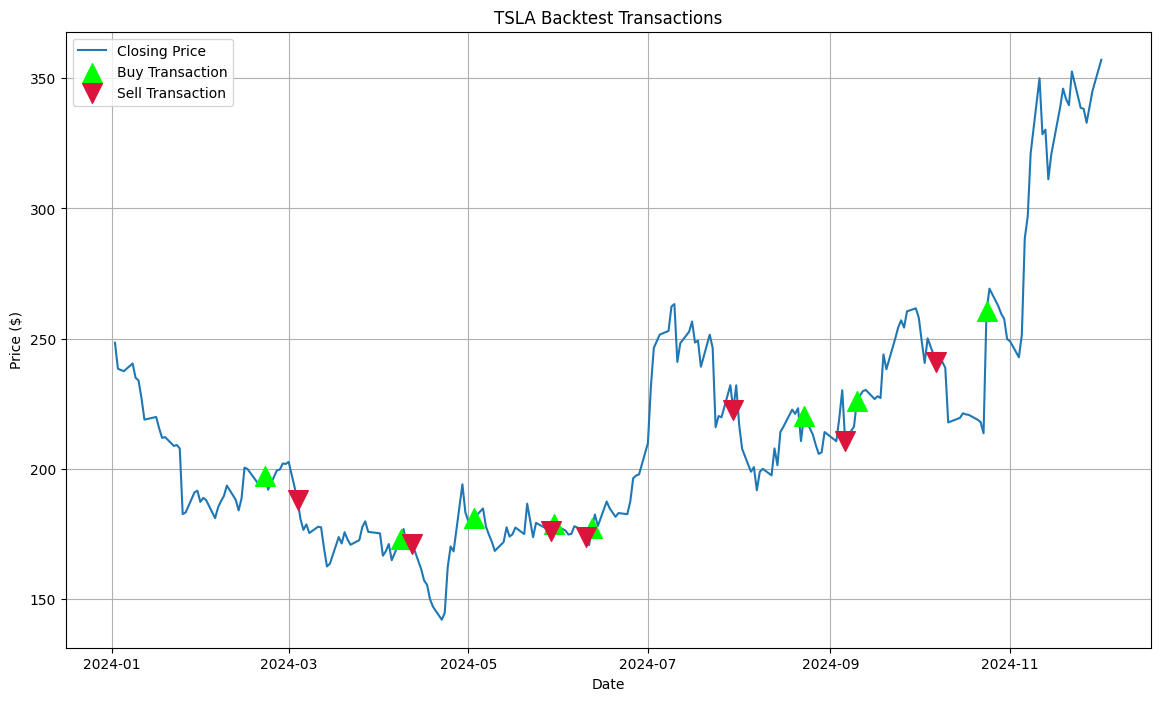

In [27]:
# Extract transaction dates and prices
buy_dates = [entry[0] for entry in transaction_details if entry[1] == "BUY"]
buy_prices = [df.loc[str(date), 'Close'] for date in buy_dates]

sell_dates = [entry[0] for entry in transaction_details if entry[1] == "SELL"]
sell_prices = [df.loc[str(date), 'Close'] for date in sell_dates]

# Plot trades on price chart
plt.figure(figsize=(14, 8))

# Plot the closing price
plt.plot(df.index, df['Close'], label='Closing Price')

# Highlight Buy and Sell Transactions
plt.scatter(buy_dates, buy_prices, label='Buy Transaction', marker='^', color='lime', s=200, zorder=5)
plt.scatter(sell_dates, sell_prices, label='Sell Transaction', marker='v', color='crimson', s=200, zorder=5)

# Add labels, legend, and title
plt.title(f"{stock_symbol} Backtest Transactions")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend(loc='upper left')
plt.grid()

# Save the plot
plt.savefig(f"{stock_symbol}_Backtest_Transactions.png", dpi=300)

# Show the plot
plt.show()
